In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os


In [10]:
# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 28*28),
            nn.Tanh()  # Output between -1 and 1
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 1, 28, 28)
        return img

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


In [11]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Scale images to [-1, 1]
])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)


In [15]:
# Initialize models
generator = Generator()
discriminator = Discriminator()

# Loss and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# For tracking losses
g_losses = []
d_losses = []

# For saving sample images
os.makedirs("images", exist_ok=True)

# Training
epochs = 100
for epoch in range(epochs + 1):
    for i, (imgs, _) in enumerate(dataloader):

        batch_size = imgs.size(0)

        # Real and Fake labels
        valid = torch.ones(batch_size, 1)
        fake = torch.zeros(batch_size, 1)

        # ------------
        # Train Generator
        # ------------
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, 100)
        gen_imgs = generator(z)

        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # ------------
        # Train Discriminator
        # ------------
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    # Save losses
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    # Print progress
    print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Save sample images
    if epoch in [0, 50, 100]:
        with torch.no_grad():
            sample_z = torch.randn(64, 100)
            sample_imgs = generator(sample_z)
            sample_imgs = sample_imgs.view(-1, 1, 28, 28)
            grid = np.transpose(torchvision.utils.make_grid(sample_imgs, nrow=8, normalize=True).cpu(), (1, 2, 0))
            plt.figure(figsize=(8, 8))
            plt.imshow(grid)
            plt.axis('off')
            plt.title(f'Sample Images at Epoch {epoch}')
            plt.savefig(f"images/sample_epoch_{epoch}.png")
            plt.show()


Epoch 0 | D Loss: 0.0216 | G Loss: 4.0401


NameError: name 'torchvision' is not defined

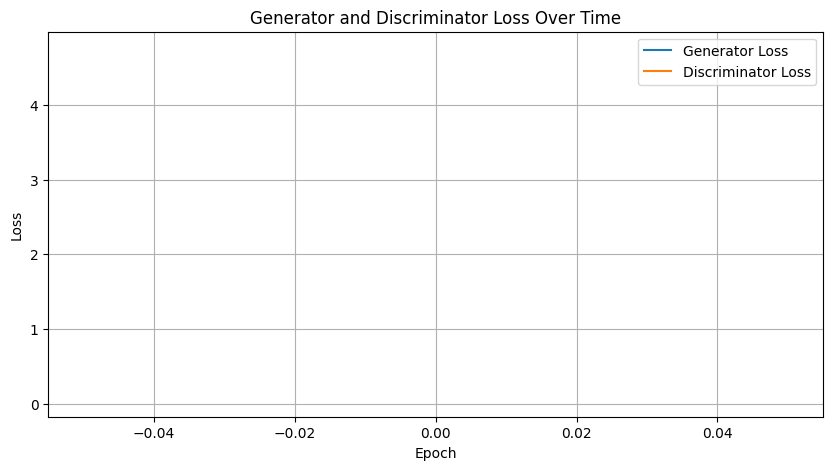

In [13]:
# Plot Generator and Discriminator losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.title("Generator and Discriminator Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("images/loss_plot.png")
plt.show()
